import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
# Libraries

In [1]:
#import modin.pandas as pd
import warnings
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import resample
from pandas_profiling import ProfileReport
import pyforest
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_selection import RFECV as RFECV_SKYLEARN
pd.options.display.max_columns = 100
#pd.set_option('display.max_columns', None)

<IPython.core.display.Javascript object>

# Import, Clean, Merge your Key Table

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

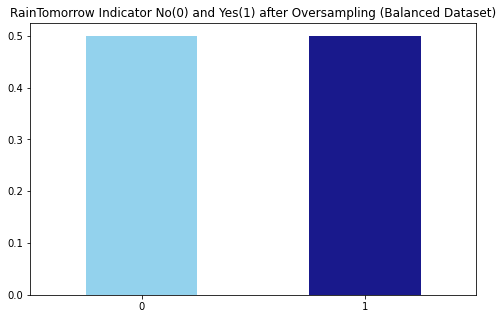

In [2]:
#Import key_table
rain_aus = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/rain_data_aus.csv")
rain_aus = rain_aus.rename(columns={"amountOfRain": "amntraintmrw"})
rain_aus['raintoday'].replace({'No': 0, 'Yes': 1},inplace = True)
rain_aus['raintomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)
rain_aus.head()
#Resample and resize variable
no = rain_aus[rain_aus.raintomorrow == 0]
yes = rain_aus[rain_aus.raintomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
rain_oversample = pd.concat([no, yes_oversampled])
#Plot and see resample
fig = plt.figure(figsize = (8,5))
rain_oversample.raintomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [3]:
#Import side_tables and concatenate in one
wind1 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_01.csv")
wind2 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_02.csv")
wind3= pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_03.csv")
wind4 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_04.csv")
wind5 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_05.csv")
wind6 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_06.csv")
wind7 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_07.csv")
wind8 = pd.read_csv("C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/wind_table_08.csv")
wind = pd.concat([wind1, wind2, wind3, wind4, wind5, wind6, wind7, wind8])
#Correct merged side_tables
cont = 2
for col in wind.columns[8:14]:
    wind.loc[~wind[col].isnull(), wind.columns[cont]] = wind.loc[~wind[col].isnull(), col]
    cont +=1
wind = wind.drop(['windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm'], axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
#Merge all tables and apply conditions to correct it
rain_merge = pd.merge(left=rain_oversample, right=wind, how='left', on=['date', 'location'])
rain_merge['date'] = pd.to_datetime(rain_merge['date'].str.strip(), format='%Y/%m/%d')
rain_merge.loc[(rain_merge.amntraintmrw < 0.4),'amntraintmrw']=0
#Duplicates
    #rain_merge.groupby(rain_merge.columns.tolist(),as_index=False).size())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
#Correct type from columns
rain_merge['wind_gustdir'] = rain_merge['wind_gustdir'].astype(str)
rain_merge['wind_dir9am'] = rain_merge['wind_dir9am'].astype(str)
rain_merge['wind_dir3pm'] = rain_merge['wind_dir3pm'].astype(str)
#turn it into a scale
encoder = LabelEncoder()
encoder.fit(rain_merge['wind_gustdir'])
#transform
rain_merge['wind_gustdir'] = encoder.transform(rain_merge['wind_gustdir'])
rain_merge['wind_dir9am'] = encoder.transform(rain_merge['wind_dir9am'])
rain_merge['wind_dir3pm'] = encoder.transform(rain_merge['wind_dir3pm'])

In [6]:
#see min and max from table
print(rain_merge['date'].min())
print(rain_merge['date'].max())

2007-11-01 00:00:00
2017-06-25 00:00:00


In [7]:
rain_merge['raintomorrow'].value_counts()

1    128357
0    127338
Name: raintomorrow, dtype: int64

In [8]:
#Create a table by your current season (apply one month ago + actual month + next month)
seasoned_rain = rain_merge[(rain_merge['date'].dt.month == 4) | (rain_merge['date'].dt.month == 5) | (rain_merge['date'].dt.month == 6)]
seasoned_rain = seasoned_rain[~(seasoned_rain['date'].dt.year <= 2007)]
#seasoned_rain = seasoned_rain[~(seasoned_rain['date'].dt.year >= 2017)]
#Split Date in columns
seasoned_rain_all = seasoned_rain
seasoned_rain['year'] = pd.to_datetime(seasoned_rain['date']).dt.year
seasoned_rain['month'] = pd.to_datetime(seasoned_rain['date']).dt.month
seasoned_rain['day'] = pd.to_datetime(seasoned_rain['date']).dt.day
seasoned_rain.drop('date',
  axis='columns', inplace=True)
rain_merge_all = rain_merge
rain_merge['year'] = pd.to_datetime(rain_merge['date']).dt.year
rain_merge['month'] = pd.to_datetime(rain_merge['date']).dt.month
rain_merge['day'] = pd.to_datetime(rain_merge['date']).dt.day
rain_merge.drop('date',
  axis='columns', inplace=True)
#Export your table cleaned
rain_merge.to_csv('C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/rain_cleaned.csv', index = False, header=True)
seasoned_rain.to_csv('C:/Users/user/2. GIT_PROJECTS/Desafios/Projeto 4 - Itau/case/data/seasoned_rain.csv', index = False, header=True)
#see min and max from table
print(rain_merge['year'].min())
print(rain_merge['year'].max())
print(seasoned_rain['year'].min())
print(seasoned_rain['year'].max())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2007
2017
2008
2017


In [9]:
seasoned_rain['raintomorrow'].value_counts()

1    36783
0    34785
Name: raintomorrow, dtype: int64

In [10]:
#Check your final table!
seasoned_rain

location  mintemp  maxtemp  rainfall  evaporation  sunshine  \
106         Albury     12.2     30.6       0.0          NaN       NaN   
107         Albury     10.7     21.4      12.6          NaN       NaN   
108         Albury      7.8     21.7       0.0          NaN       NaN   
109         Albury      8.1     21.4       0.0          NaN       NaN   
110         Albury      7.5     22.5       0.0          NaN       NaN   
...            ...      ...      ...       ...          ...       ...   
255683  Launceston     13.6     26.3       0.0          NaN       NaN   
255684     Walpole     12.1     22.6       0.0          NaN       NaN   
255685      Sydney      9.0     16.6       0.0          2.6       0.7   
255688       Cobar     16.5     20.6      14.4          6.0       0.0   
255689  Launceston      1.1     11.8       0.4          NaN       NaN   

        humidity9am  humidity3pm  pressure9am  pressure3pm  cloud9am  \
106            59.0         22.0       1022.6       1019.4       NaN   
107            60.0         33.0       1019.8       1019.3       NaN   
108            72.0         37.0       1020.4       1016.5       NaN   
109            58.0         20.0       1021.8       1019.6       NaN   
110            55.0         27.0       1026.7       1023.5       NaN   
...             ...          ...          ...          ...       ...   
255683         90.0         63.0       1016.5       1013.1       NaN   
255684         93.0         61.0       1020.6       1019.7       NaN   
255685         86.0         62.0       1034.2       1032.6       NaN   
255688         97.0         76.0       1021.3       1019.3       7.0   
255689         97.0         98.0       1020.1       1013.3       NaN   

        cloud3pm  temp9am  temp3pm  raintoday  amntraintmrw  raintomorrow  \
106          NaN     16.6     29.5        0.0           0.0             0   
107          NaN     13.9     20.3        1.0           0.0             0   
108          NaN     12.9     21.2        0.0           0.0             0   
109          NaN     13.8     20.9        0.0           0.0             0   
110          NaN     13.3     21.6        0.0           0.0             0   
...          ...      ...      ...        ...           ...           ...   
255683       NaN     16.6     25.2        0.0           2.0             1   
255684       NaN     18.3     20.8        0.0           2.0             1   
255685       NaN     10.7     16.3        0.0           2.8             1   
255688       7.0     16.9     19.9        1.0           2.4             1   
255689       NaN      4.0      9.5        0.0           8.8             1   

         temp  humidity  precipitation3pm  precipitation9am  modelo_vigente  \
106     38.72      28.4                 9         14.678197        0.002080   
107     27.68      41.6                 5         12.263640        0.019179   
108     28.04      46.4                11         17.192096        0.017412   
109     27.68      26.0                 8          7.616789        0.004255   
110     29.00      34.4                 9         12.355752        0.002450   
...       ...       ...               ...               ...             ...   
255683  33.56      77.6                 6         10.377760        0.492082   
255684  29.12      75.2                 9         12.304119        0.116448   
255685  21.92      76.4                13          6.271089        0.478635   
255688  26.72      93.2                 8         21.681652        0.800521   
255689  16.16     119.6                 9          9.109173        0.877160   

        wind_gustdir  wind_gustspeed  wind_dir9am  wind_dir3pm  wind_speed9am  \
106                9            22.0           16            1            0.0   
107               13            43.0           16           15            0.0   
108               15            31.0            0            7            6.0   
109               13            35.0           10           15        

In [11]:
seasoned_rain['raintomorrow'].value_counts()

1    36783
0    34785
Name: raintomorrow, dtype: int64

In [12]:
seasoned_rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71568 entries, 106 to 255689
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   location          71568 non-null  object 
 1   mintemp           71060 non-null  float64
 2   maxtemp           71400 non-null  float64
 3   rainfall          70615 non-null  float64
 4   evaporation       37141 non-null  float64
 5   sunshine          33703 non-null  float64
 6   humidity9am       70306 non-null  float64
 7   humidity3pm       68902 non-null  float64
 8   pressure9am       64722 non-null  float64
 9   pressure3pm       64712 non-null  float64
 10  cloud9am          44563 non-null  float64
 11  cloud3pm          42553 non-null  float64
 12  temp9am           71044 non-null  float64
 13  temp3pm           69583 non-null  float64
 14  raintoday         70615 non-null  float64
 15  amntraintmrw      71568 non-null  float64
 16  raintomorrow      71568 non-null  int

# Create your Pipeline

In [15]:
#Your pipeline to clean your data for your problem and manage it:
#seasoned_rain.drop(['raintomorrow', 'amntraintmrw', 'modelo_vigente', 'temp', 'temp9am', 'temp3pm', 'humidity'], axis=1)

In [16]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

ordinalencoder = OrdinalEncoder()
onehotencoder = OneHotEncoder(drop='first',  handle_unknown='error')
cat_imputer = SimpleImputer(strategy='most_frequent')

#labelencoder = LabelEncoder()
#encoder.fit(df['wind_gustdir'])

#df['wind_gustdir'] = encoder.transform(df['wind_gustdir'])
#df['wind_dir9am'] = encoder.transform(df['wind_dir9am'])
#df['wind_dir3pm'] = encoder.transform(df['wind_dir3pm'])

In [17]:
categorical_pipeline = Pipeline(steps=[('missing', cat_imputer),
                                       ('encode', ordinalencoder)])

In [18]:
from sklearn.preprocessing import StandardScaler

numerical_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

In [19]:
numerical_pipeline = Pipeline(steps=[('missing', numerical_imputer),
                                     ('standardize', scaler)])

In [20]:
from sklearn.compose import ColumnTransformer

dataprep = ColumnTransformer(transformers=[('numerical_transform', numerical_pipeline, [num_columns]),
                                           ('categ_transform', categorical_pipeline, cat_columns)])

In [21]:
dataprep.fit(X,y)

location  mintemp  maxtemp  rainfall  evaporation  sunshine  \
106         Albury     12.2     30.6       0.0          NaN       NaN   
107         Albury     10.7     21.4      12.6          NaN       NaN   
108         Albury      7.8     21.7       0.0          NaN       NaN   
109         Albury      8.1     21.4       0.0          NaN       NaN   
110         Albury      7.5     22.5       0.0          NaN       NaN   
...            ...      ...      ...       ...          ...       ...   
255683  Launceston     13.6     26.3       0.0          NaN       NaN   
255684     Walpole     12.1     22.6       0.0          NaN       NaN   
255685      Sydney      9.0     16.6       0.0          2.6       0.7   
255688       Cobar     16.5     20.6      14.4          6.0       0.0   
255689  Launceston      1.1     11.8       0.4          NaN       NaN   

        humidity9am  humidity3pm  pressure9am  pressure3pm  cloud9am  \
106            59.0         22.0       1022.6       1019.4       NaN   
107            60.0         33.0       1019.8       1019.3       NaN   
108            72.0         37.0       1020.4       1016.5       NaN   
109            58.0         20.0       1021.8       1019.6       NaN   
110            55.0         27.0       1026.7       1023.5       NaN   
...             ...          ...          ...          ...       ...   
255683         90.0         63.0       1016.5       1013.1       NaN   
255684         93.0         61.0       1020.6       1019.7       NaN   
255685         86.0         62.0       1034.2       1032.6       NaN   
255688         97.0         76.0       1021.3       1019.3       7.0   
255689         97.0         98.0       1020.1       1013.3       NaN   

        cloud3pm  temp9am  temp3pm  raintoday  amntraintmrw  raintomorrow  \
106          NaN     16.6     29.5        0.0           0.0             0   
107          NaN     13.9     20.3        1.0           0.0             0   
108          NaN     12.9     21.2        0.0           0.0             0   
109          NaN     13.8     20.9        0.0           0.0             0   
110          NaN     13.3     21.6        0.0           0.0             0   
...          ...      ...      ...        ...           ...           ...   
255683       NaN     16.6     25.2        0.0           2.0             1   
255684       NaN     18.3     20.8        0.0           2.0             1   
255685       NaN     10.7     16.3        0.0           2.8             1   
255688       7.0     16.9     19.9        1.0           2.4             1   
255689       NaN      4.0      9.5        0.0           8.8             1   

         temp  humidity  precipitation3pm  precipitation9am  modelo_vigente  \
106     38.72      28.4                 9         14.678197        0.002080   
107     27.68      41.6                 5         12.263640        0.019179   
108     28.04      46.4                11         17.192096        0.017412   
109     27.68      26.0                 8          7.616789        0.004255   
110     29.00      34.4                 9         12.355752        0.002450   
...       ...       ...               ...               ...             ...   
255683  33.56      77.6                 6         10.377760        0.492082   
255684  29.12      75.2                 9         12.304119        0.116448   
255685  21.92      76.4                13          6.271089        0.478635   
255688  26.72      93.2                 8         21.681652        0.800521   
255689  16.16     119.6                 9          9.109173        0.877160   

        wind_gustdir  wind_gustspeed  wind_dir9am  wind_dir3pm  wind_speed9am  \
106                9            22.0           16            1            0.0   
107               13            43.0           16           15            0.0   
108               15            31.0            0            7            6.0   
109               13            35.0           10           15        

# If you want to explore your data with graphs (TAKES TIME!!)

In [20]:
#Export an automated exploratory analysys (takes time to process it!!)
prof = ProfileReport(rain_merge, title="Rain in Austraia Seasoned Report", explorative=True)
prof.to_file(output_file='Australia Rain Seasoned Report.html')

Summarize dataset:   0%|          | 0/44 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\test\lib\site-packages\scipy\stats\stats.py:4594: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Predict the future!

## Find your best model (HEAVY JOB!)

In [22]:
seasoned_rain

location  mintemp  maxtemp  rainfall  evaporation  sunshine  \
106         Albury     12.2     30.6       0.0          NaN       NaN   
107         Albury     10.7     21.4      12.6          NaN       NaN   
108         Albury      7.8     21.7       0.0          NaN       NaN   
109         Albury      8.1     21.4       0.0          NaN       NaN   
110         Albury      7.5     22.5       0.0          NaN       NaN   
...            ...      ...      ...       ...          ...       ...   
255683  Launceston     13.6     26.3       0.0          NaN       NaN   
255684     Walpole     12.1     22.6       0.0          NaN       NaN   
255685      Sydney      9.0     16.6       0.0          2.6       0.7   
255688       Cobar     16.5     20.6      14.4          6.0       0.0   
255689  Launceston      1.1     11.8       0.4          NaN       NaN   

        humidity9am  humidity3pm  pressure9am  pressure3pm  cloud9am  \
106            59.0         22.0       1022.6       1019.4       NaN   
107            60.0         33.0       1019.8       1019.3       NaN   
108            72.0         37.0       1020.4       1016.5       NaN   
109            58.0         20.0       1021.8       1019.6       NaN   
110            55.0         27.0       1026.7       1023.5       NaN   
...             ...          ...          ...          ...       ...   
255683         90.0         63.0       1016.5       1013.1       NaN   
255684         93.0         61.0       1020.6       1019.7       NaN   
255685         86.0         62.0       1034.2       1032.6       NaN   
255688         97.0         76.0       1021.3       1019.3       7.0   
255689         97.0         98.0       1020.1       1013.3       NaN   

        cloud3pm  temp9am  temp3pm  raintoday  amntraintmrw  raintomorrow  \
106          NaN     16.6     29.5        0.0           0.0             0   
107          NaN     13.9     20.3        1.0           0.0             0   
108          NaN     12.9     21.2        0.0           0.0             0   
109          NaN     13.8     20.9        0.0           0.0             0   
110          NaN     13.3     21.6        0.0           0.0             0   
...          ...      ...      ...        ...           ...           ...   
255683       NaN     16.6     25.2        0.0           2.0             1   
255684       NaN     18.3     20.8        0.0           2.0             1   
255685       NaN     10.7     16.3        0.0           2.8             1   
255688       7.0     16.9     19.9        1.0           2.4             1   
255689       NaN      4.0      9.5        0.0           8.8             1   

         temp  humidity  precipitation3pm  precipitation9am  modelo_vigente  \
106     38.72      28.4                 9         14.678197        0.002080   
107     27.68      41.6                 5         12.263640        0.019179   
108     28.04      46.4                11         17.192096        0.017412   
109     27.68      26.0                 8          7.616789        0.004255   
110     29.00      34.4                 9         12.355752        0.002450   
...       ...       ...               ...               ...             ...   
255683  33.56      77.6                 6         10.377760        0.492082   
255684  29.12      75.2                 9         12.304119        0.116448   
255685  21.92      76.4                13          6.271089        0.478635   
255688  26.72      93.2                 8         21.681652        0.800521   
255689  16.16     119.6                 9          9.109173        0.877160   

        wind_gustdir  wind_gustspeed  wind_dir9am  wind_dir3pm  wind_speed9am  \
106                9            22.0           16            1            0.0   
107               13            43.0           16           15            0.0   
108               15            31.0            0            7            6.0   
109               13            35.0           10           15        

In [23]:
seasoned_rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71568 entries, 106 to 255689
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   location          71568 non-null  object 
 1   mintemp           71060 non-null  float64
 2   maxtemp           71400 non-null  float64
 3   rainfall          70615 non-null  float64
 4   evaporation       37141 non-null  float64
 5   sunshine          33703 non-null  float64
 6   humidity9am       70306 non-null  float64
 7   humidity3pm       68902 non-null  float64
 8   pressure9am       64722 non-null  float64
 9   pressure3pm       64712 non-null  float64
 10  cloud9am          44563 non-null  float64
 11  cloud3pm          42553 non-null  float64
 12  temp9am           71044 non-null  float64
 13  temp3pm           69583 non-null  float64
 14  raintoday         70615 non-null  float64
 15  amntraintmrw      71568 non-null  float64
 16  raintomorrow      71568 non-null  int

In [ ]:
from pycaret.classification import *
clf1 = setup(data = seasoned_rain, target = 'raintomorrow')
# return best model
best = compare_models()
# return top 3 models based on 'Accuracy'
#top3 = compare_models(n_select = 3)
# return best model based on AUC
#best = compare_models(sort = 'AUC') #default is 'Accuracy'
# compare specific models
#best_specific = compare_models(include = ['dt','rf','xgboost'])
# blacklist certain models
#best_specific = compare_models(exclude = ['catboost', 'svm'])

In [ ]:
# Automate your your search for your best columns
#rain_merge_best_columns = rain_merge
#rain_merge_best_columns = rain_merge_best_columns.drop('location', axis=1)
#rain_merge_best_columns = rain_merge_best_columns.drop('amntraintmrw', axis=1)
#X = rain_merge_best_columns 
#Split test and train
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#lgbm = LGBMClassifier(n_jobs=-1)
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_std = scaler.transform(X_train)
#X_test_std = scaler.transform(X_test)
#selector = RFECV_SKYLEARN(lgbm,scoring = 'roc_auc')
#selector.fit(X_train_std, y_train)
#X_train.columns[selector.support_]

## Run Your Model

1    89692
0    89294
Name: raintomorrow, dtype: int64
ROC_PREDIT TRAIN IS:   0.9667553155665112
ROC_PREDIT TEST IS:   0.9418336677767586
CROSS_VAL_SCORE IS (0.9408427566761745, 0.0016122324172810469)
PRECISION_SCORE TEST IS:   0.8875210138368033
RECALL_SCORE TEST IS:   0.8571928159268604
F1_SCORE TEST IS:   0.8720933187628657


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

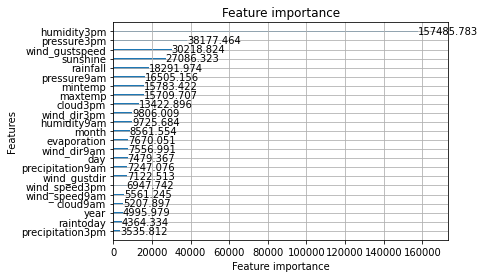

In [14]:
#Create you best model variables FOR ALL DATA
X = rain_merge[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = rain_merge['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(y_train.value_counts())
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=400, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

In [16]:
# Automate your parameters for your best model
#seasoned_rain_best_columns = seasoned_rain
#seasoned_rain_best_columns = seasoned_rain_best_columns.drop('location', axis=1)
#seasoned_rain_best_columns = seasoned_rain_best_columns.drop('amntraintmrw', axis=1)
#X = seasoned_rain_best_columns 
#Split test and train
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#lgbm = LGBMClassifier(n_jobs=-1)
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_std = scaler.transform(X_train)
#X_test_std = scaler.transform(X_test)
#selector = RFECV_SKYLEARN(lgbm,scoring = 'roc_auc')
#selector.fit(X_train_std, y_train)
#X_train.columns[selector.support_]

1    25731
0    24366
Name: raintomorrow, dtype: int64
ROC_PREDIT TRAIN IS:   0.9989813872891019
ROC_PREDIT TEST IS:   0.9765921358697086
CROSS_VAL_SCORE IS (0.9770235946660069, 0.0026008030667999406)
PRECISION_SCORE TEST IS:   0.9618168657256605
RECALL_SCORE TEST IS:   0.9130733550936265
F1_SCORE TEST IS:   0.9368114920243236


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

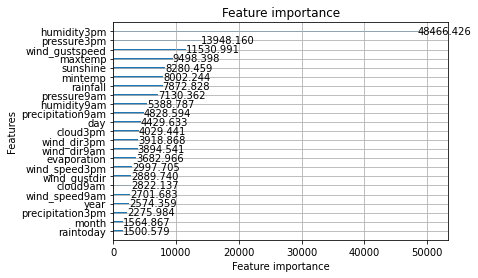

In [17]:
#Create you best model variables FOR YOUR SEASONAL CUT
X = seasoned_rain[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = seasoned_rain['raintomorrow']
#Create you best model variables FOR ALL DATA
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(y_train.value_counts())
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=400, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

# By City

In [18]:
#Find and list your cities from primary table
dfs = dict(tuple(seasoned_rain.groupby('location')))
cities_list = list(dfs)
print(cities_list)

['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek', 'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar', 'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart', 'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport', 'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle', 'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF', 'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale', 'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville', 'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia', 'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera']


C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9977790325616412
CROSS_VAL_SCORE IS (0.9852602265766561, 0.01283920969094838)
PRECISION_SCORE TEST IS:   0.9960474308300395
RECALL_SCORE TEST IS:   0.9438202247191011
F1_SCORE TEST IS:   0.9692307692307691


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

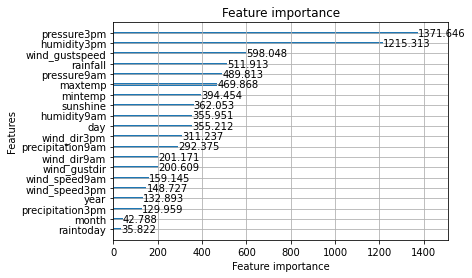

In [19]:
Adelaide = dfs['Adelaide']
#Create you best model variables
X = Adelaide[['mintemp', 'maxtemp', 'rainfall', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Adelaide['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1

print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9761163826820393
CROSS_VAL_SCORE IS (0.9784837737973259, 0.018592730658211376)
PRECISION_SCORE TEST IS:   0.9772727272727273
RECALL_SCORE TEST IS:   0.9184466019417475
F1_SCORE TEST IS:   0.9469469469469469


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

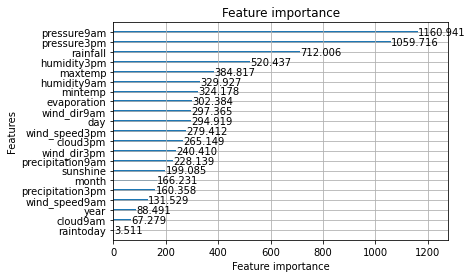

In [20]:
Albany = dfs['Albany']
#Create you best model variables
X = Albany[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Albany['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9951486013986015
CROSS_VAL_SCORE IS (0.9929575737778572, 0.006317079606453429)
PRECISION_SCORE TEST IS:   0.98125
RECALL_SCORE TEST IS:   0.9401197604790419
F1_SCORE TEST IS:   0.9602446483180428


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

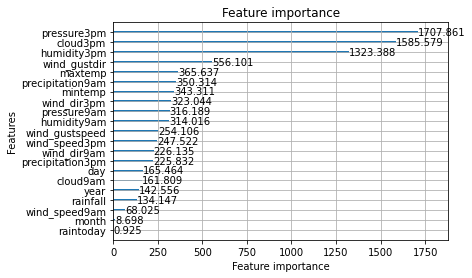

In [21]:
Albury =  dfs['Albury']
X = Albury[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Albury['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   1.0
CROSS_VAL_SCORE IS (0.9961651745999571, 0.01055187997241204)
PRECISION_SCORE TEST IS:   1.0
RECALL_SCORE TEST IS:   0.9459459459459459
F1_SCORE TEST IS:   0.9722222222222222


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

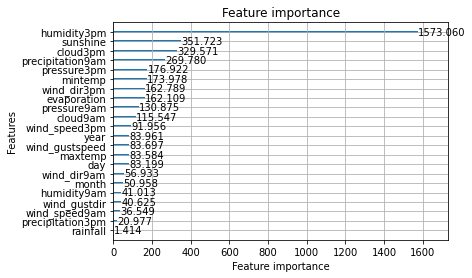

In [22]:
AliceSprings = dfs['AliceSprings']
X = AliceSprings[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = AliceSprings['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.988839893298492
CROSS_VAL_SCORE IS (0.9907359649660012, 0.009790196146305911)
PRECISION_SCORE TEST IS:   0.9487179487179487
RECALL_SCORE TEST IS:   0.9173553719008265
F1_SCORE TEST IS:   0.9327731092436975


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

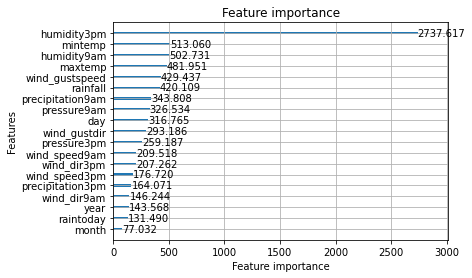

In [23]:
BadgerysCreek = dfs['BadgerysCreek']
X = BadgerysCreek[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = BadgerysCreek['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9818236522600969
CROSS_VAL_SCORE IS (0.9849759504826959, 0.006631294776902268)
PRECISION_SCORE TEST IS:   0.9844961240310077
RECALL_SCORE TEST IS:   0.9039145907473309
F1_SCORE TEST IS:   0.9424860853432282


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

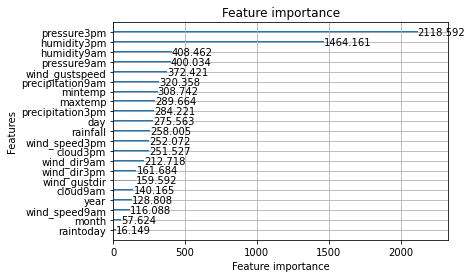

In [24]:
Ballarat = dfs['Ballarat']
X = Ballarat[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Ballarat['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9915584415584416
CROSS_VAL_SCORE IS (0.9973366888564946, 0.003975576893523507)
PRECISION_SCORE TEST IS:   0.9846153846153847
RECALL_SCORE TEST IS:   0.9624060150375939
F1_SCORE TEST IS:   0.973384030418251


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

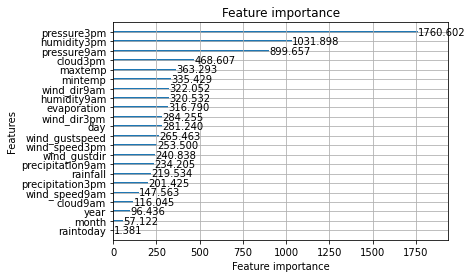

In [25]:
Bendigo = dfs['Bendigo']
X = Bendigo[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Bendigo['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   0.9999999999999999
ROC_PREDIT TEST IS:   0.9874317173096621
CROSS_VAL_SCORE IS (0.9919887317348562, 0.0077488774710817825)
PRECISION_SCORE TEST IS:   0.9603960396039604
RECALL_SCORE TEST IS:   0.9603960396039604
F1_SCORE TEST IS:   0.9603960396039604


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

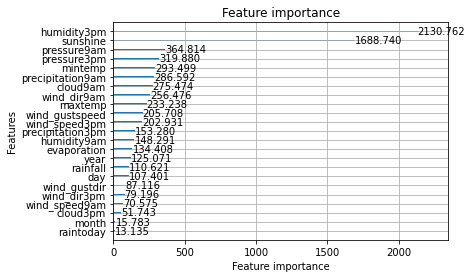

In [26]:
Brisbane = dfs['Brisbane']
X = Brisbane[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Brisbane['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9937462775461584
CROSS_VAL_SCORE IS (0.9849218558633593, 0.01319271593160224)
PRECISION_SCORE TEST IS:   0.9836956521739131
RECALL_SCORE TEST IS:   0.9378238341968912
F1_SCORE TEST IS:   0.960212201591512


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

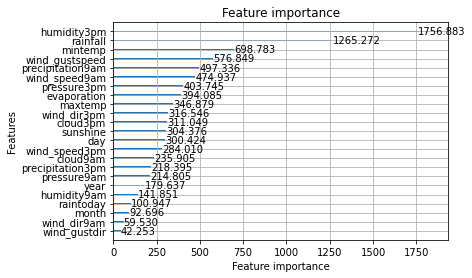

In [27]:
Cairns = dfs['Cairns']
X = Cairns[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Cairns['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9897328406991616
CROSS_VAL_SCORE IS (0.9791938064078238, 0.006464779908277421)
PRECISION_SCORE TEST IS:   0.9596774193548387
RECALL_SCORE TEST IS:   0.9260700389105059
F1_SCORE TEST IS:   0.9425742574257425


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

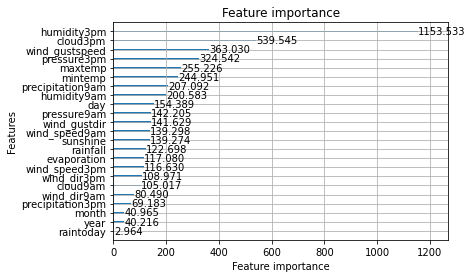

In [28]:
Canberra = dfs['Canberra']
X = Canberra[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Canberra['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   1.0
CROSS_VAL_SCORE IS (0.9953383562066648, 0.0072501032550699)
PRECISION_SCORE TEST IS:   1.0
RECALL_SCORE TEST IS:   0.9
F1_SCORE TEST IS:   0.9473684210526316


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

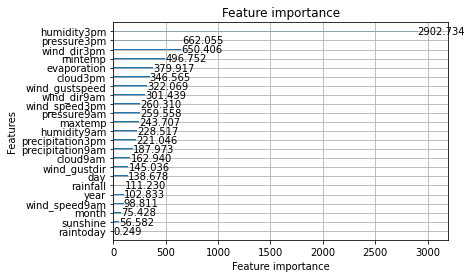

In [29]:
Cobar = dfs['Cobar']
X = Cobar[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Cobar['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,  random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.996145480135628
CROSS_VAL_SCORE IS (0.9895222990829229, 0.013026447791065297)
PRECISION_SCORE TEST IS:   1.0
RECALL_SCORE TEST IS:   0.9361702127659575
F1_SCORE TEST IS:   0.967032967032967


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

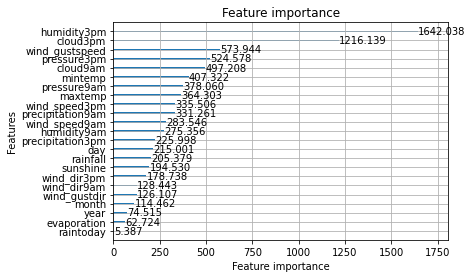

In [30]:
CoffsHarbour = dfs['CoffsHarbour']
X = CoffsHarbour[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = CoffsHarbour['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.982905027932961
CROSS_VAL_SCORE IS (0.9867995176134506, 0.009354331937069499)
PRECISION_SCORE TEST IS:   0.98
RECALL_SCORE TEST IS:   0.937799043062201
F1_SCORE TEST IS:   0.9584352078239609


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

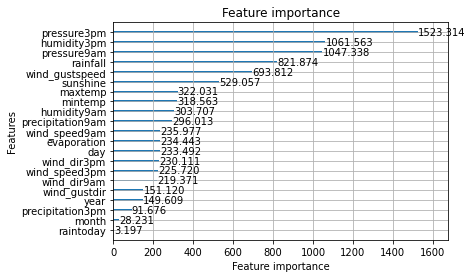

In [31]:
Dartmoor = dfs['Dartmoor']
X = Dartmoor[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Dartmoor['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9945117029862792
CROSS_VAL_SCORE IS (0.994592412454763, 0.006454609737570265)
PRECISION_SCORE TEST IS:   0.9714285714285714
RECALL_SCORE TEST IS:   0.9855072463768116
F1_SCORE TEST IS:   0.9784172661870504


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

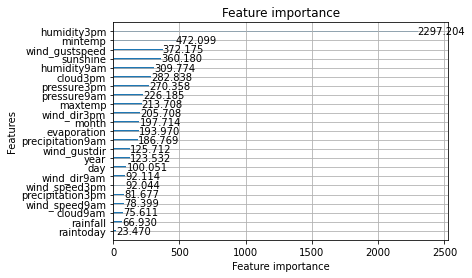

In [32]:
Darwin = dfs['Darwin']
X = Darwin[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Darwin['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.988321634971104
CROSS_VAL_SCORE IS (0.9915143167901403, 0.0077782753185384555)
PRECISION_SCORE TEST IS:   0.9746835443037974
RECALL_SCORE TEST IS:   0.9390243902439024
F1_SCORE TEST IS:   0.9565217391304348


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

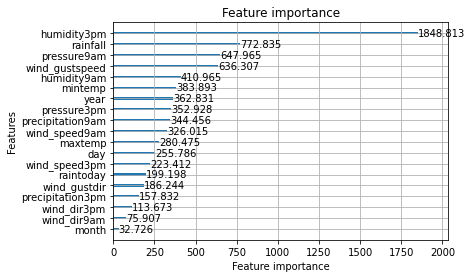

In [33]:
GoldCoast = dfs['GoldCoast']
X = GoldCoast[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = GoldCoast['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   0.9999999999999999
ROC_PREDIT TEST IS:   0.9989364417595507
CROSS_VAL_SCORE IS (0.990402211098391, 0.010959537524944479)
PRECISION_SCORE TEST IS:   0.9937888198757764
RECALL_SCORE TEST IS:   0.9580838323353293
F1_SCORE TEST IS:   0.9756097560975608


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

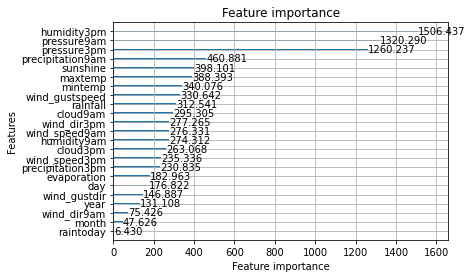

In [34]:
Hobart = dfs['Hobart']
X = Hobart[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Hobart['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9999999999999999
CROSS_VAL_SCORE IS (0.9886321195144724, 0.03198440773549167)
PRECISION_SCORE TEST IS:   0.9444444444444444
RECALL_SCORE TEST IS:   1.0
F1_SCORE TEST IS:   0.9714285714285714


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

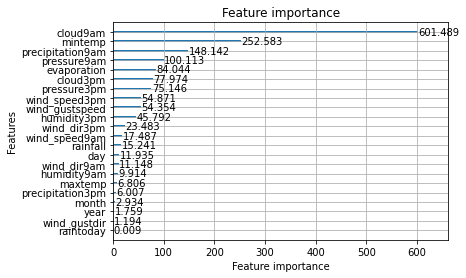

In [35]:
Katherine = dfs['Katherine']
X = Katherine[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Katherine['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9985486211901307
CROSS_VAL_SCORE IS (0.991489966626143, 0.008916898302843099)
PRECISION_SCORE TEST IS:   1.0
RECALL_SCORE TEST IS:   0.9298245614035088
F1_SCORE TEST IS:   0.9636363636363636


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

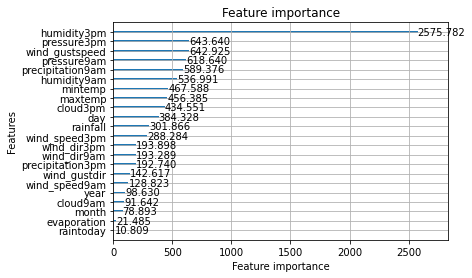

In [36]:
Launceston = dfs['Launceston']
X = Launceston[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Launceston['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.993531202435312
CROSS_VAL_SCORE IS (0.9931455183218585, 0.008158731542215338)
PRECISION_SCORE TEST IS:   0.9863013698630136
RECALL_SCORE TEST IS:   0.9290322580645162
F1_SCORE TEST IS:   0.9568106312292358


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

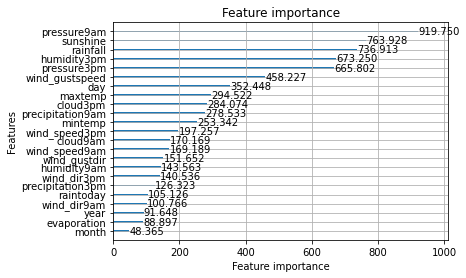

In [37]:
Melbourne = dfs['Melbourne']
X = Melbourne[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Melbourne['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9979247615683504
CROSS_VAL_SCORE IS (0.9872603643468796, 0.00841526845157199)
PRECISION_SCORE TEST IS:   0.993421052631579
RECALL_SCORE TEST IS:   0.94375
F1_SCORE TEST IS:   0.967948717948718


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

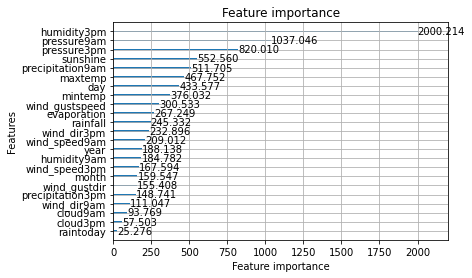

In [38]:
MelbourneAirport = dfs['MelbourneAirport']
X = MelbourneAirport[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = MelbourneAirport['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9878293135435994
CROSS_VAL_SCORE IS (0.9929475232303936, 0.015378746480774622)
PRECISION_SCORE TEST IS:   0.948051948051948
RECALL_SCORE TEST IS:   0.9125
F1_SCORE TEST IS:   0.929936305732484


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

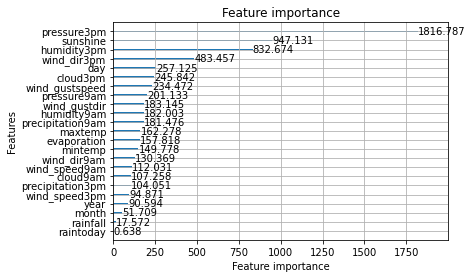

In [39]:
Mildura = dfs['Mildura']
X = Mildura[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Mildura['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

In [40]:
More = dfs['Moree']
X = More[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = More['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE!
print('ROC_AUC_SCORE TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_AUC_SCORE TEST IS:  ', roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('KFOLD SCORE IS:  ', (np.mean(results), np.std(results)))

ROC_AUC_SCORE TRAIN IS:   0.9745755607962356
ROC_AUC_SCORE TEST IS:   0.952328688681046
KFOLD SCORE IS:   (0.9588721120573414, 0.018922961541999486)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9805845084815041
CROSS_VAL_SCORE IS (0.9956277689949902, 0.003796859542891256)
PRECISION_SCORE TEST IS:   0.9785407725321889
RECALL_SCORE TEST IS:   0.946058091286307
F1_SCORE TEST IS:   0.9620253164556961


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

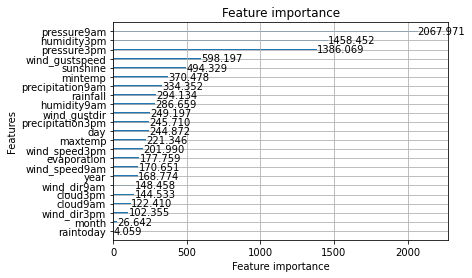

In [41]:
MountGambier = dfs['MountGambier']
X = MountGambier[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = MountGambier['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9978592702903946
CROSS_VAL_SCORE IS (0.9908225854755341, 0.008320180020207305)
PRECISION_SCORE TEST IS:   0.9873417721518988
RECALL_SCORE TEST IS:   0.9176470588235294
F1_SCORE TEST IS:   0.9512195121951219


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

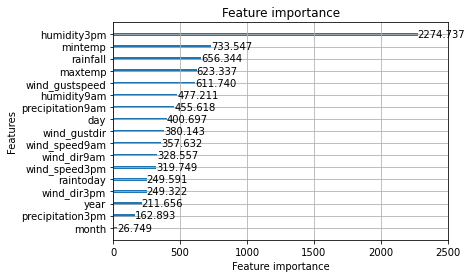

In [42]:
MountGinini = dfs['MountGinini']
X = MountGinini[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = MountGinini['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9822169115062908
CROSS_VAL_SCORE IS (0.9729160056661218, 0.017471168854210555)
PRECISION_SCORE TEST IS:   0.968299711815562
RECALL_SCORE TEST IS:   0.9032258064516129
F1_SCORE TEST IS:   0.9346314325452016


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

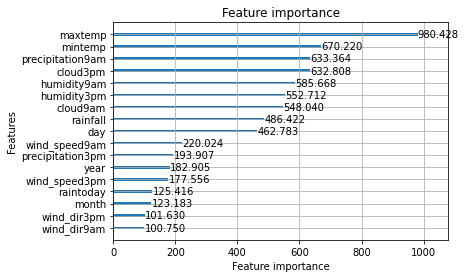

In [43]:
Newcastle = dfs['Newcastle']
X = Newcastle[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Newcastle['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9975961538461539
CROSS_VAL_SCORE IS (0.9932722785084447, 0.009029654364384668)
PRECISION_SCORE TEST IS:   0.9821428571428571
RECALL_SCORE TEST IS:   0.9401709401709402
F1_SCORE TEST IS:   0.9606986899563319


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

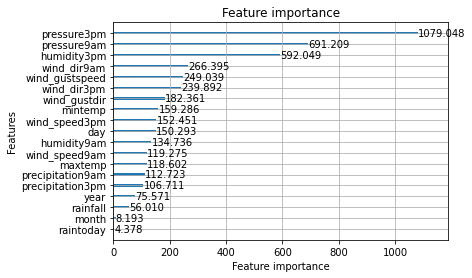

In [44]:
Nhil = dfs['Nhil']
X = Nhil[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Nhil['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9975532527345999
CROSS_VAL_SCORE IS (0.9910209900528312, 0.009960002281111447)
PRECISION_SCORE TEST IS:   0.9792746113989638
RECALL_SCORE TEST IS:   0.949748743718593
F1_SCORE TEST IS:   0.9642857142857144


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

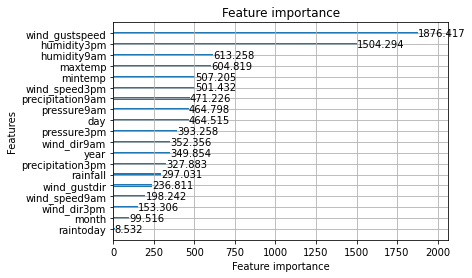

In [45]:
NorahHead = dfs['NorahHead']
X = NorahHead[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = NorahHead['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9949979991996798
CROSS_VAL_SCORE IS (0.9821624115400782, 0.009729032618431365)
PRECISION_SCORE TEST IS:   0.9915966386554622
RECALL_SCORE TEST IS:   0.932806324110672
F1_SCORE TEST IS:   0.9613034623217923


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

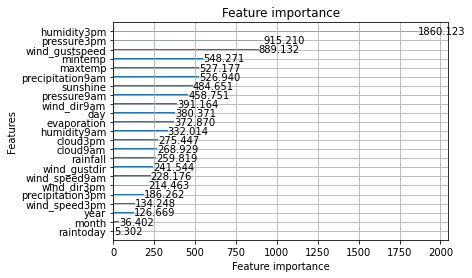

In [46]:
NorfolkIsland = dfs['NorfolkIsland']
X = NorfolkIsland[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = NorfolkIsland['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9862046131773534
CROSS_VAL_SCORE IS (0.99158647646685, 0.006901697454640234)
PRECISION_SCORE TEST IS:   0.967479674796748
RECALL_SCORE TEST IS:   0.9333333333333333
F1_SCORE TEST IS:   0.9500998003992016


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

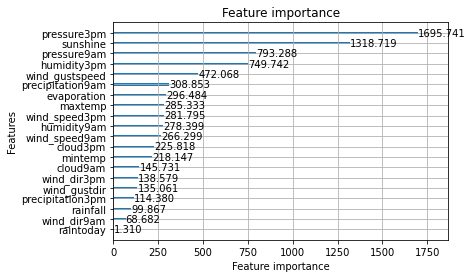

In [47]:
Nuriootpa = dfs['Nuriootpa']
X = Nuriootpa[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']]
y = Nuriootpa['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9874031007751938
CROSS_VAL_SCORE IS (0.9939960298774763, 0.006262168121934732)
PRECISION_SCORE TEST IS:   0.9953703703703703
RECALL_SCORE TEST IS:   0.9388646288209607
F1_SCORE TEST IS:   0.9662921348314606


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

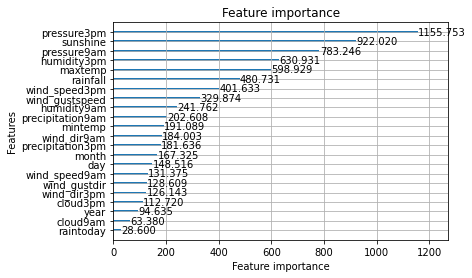

In [48]:
PearceRAAF = dfs['PearceRAAF']
X = PearceRAAF[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = PearceRAAF['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9979296066252588
CROSS_VAL_SCORE IS (0.9923686026261909, 0.009919856620017027)
PRECISION_SCORE TEST IS:   0.9523809523809523
RECALL_SCORE TEST IS:   0.9900990099009901
F1_SCORE TEST IS:   0.970873786407767


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

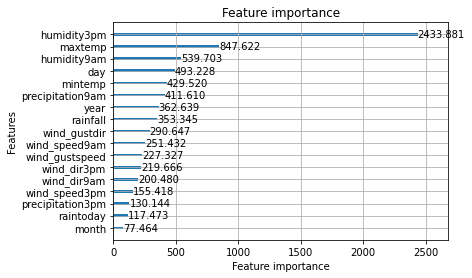

In [49]:
Penrith = dfs['Penrith']
X = Penrith[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Penrith['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9981137041586243
CROSS_VAL_SCORE IS (0.9937224900135038, 0.006895286527012833)
PRECISION_SCORE TEST IS:   0.9634146341463414
RECALL_SCORE TEST IS:   0.9634146341463414
F1_SCORE TEST IS:   0.9634146341463414


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

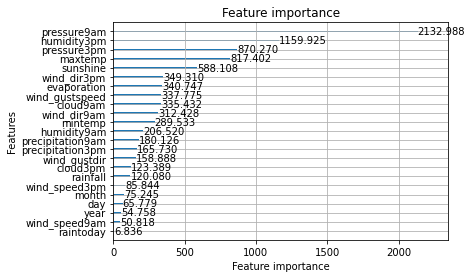

In [50]:
Perth = dfs['Perth']
X = Perth[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Perth['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9990000000000001
CROSS_VAL_SCORE IS (0.9961699397761423, 0.00431332458834512)
PRECISION_SCORE TEST IS:   0.9875
RECALL_SCORE TEST IS:   0.9693251533742331
F1_SCORE TEST IS:   0.978328173374613


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

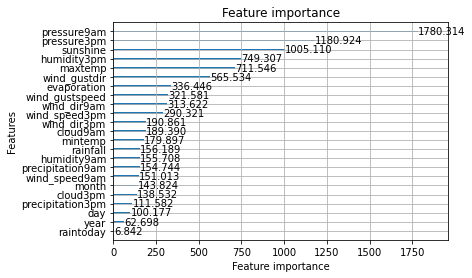

In [51]:
PerthAirport = dfs['PerthAirport']
X = PerthAirport[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = PerthAirport['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9847176079734219
CROSS_VAL_SCORE IS (0.9870259577141752, 0.00793436118867059)
PRECISION_SCORE TEST IS:   0.9833887043189369
RECALL_SCORE TEST IS:   0.9517684887459807
F1_SCORE TEST IS:   0.9673202614379085


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

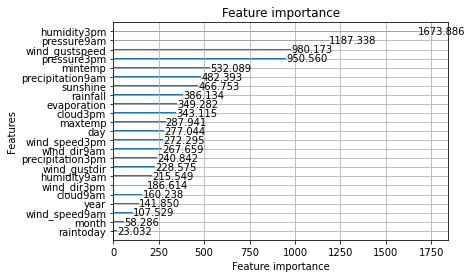

In [52]:
Portland = dfs['Portland']
X = Portland[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Portland['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9873589227846686
CROSS_VAL_SCORE IS (0.9822519936681051, 0.013314414820106334)
PRECISION_SCORE TEST IS:   0.9473684210526315
RECALL_SCORE TEST IS:   0.968609865470852
F1_SCORE TEST IS:   0.9578713968957872


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

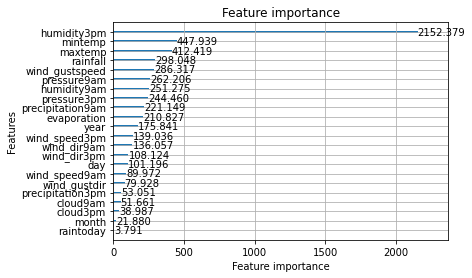

In [53]:
Richmond = dfs['Richmond']
X = Richmond[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Richmond['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9890746638358103
CROSS_VAL_SCORE IS (0.9882329252127992, 0.007275819830319706)
PRECISION_SCORE TEST IS:   0.9652777777777778
RECALL_SCORE TEST IS:   0.9205298013245033
F1_SCORE TEST IS:   0.9423728813559322


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

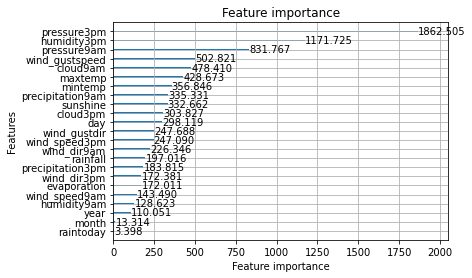

In [54]:
Sale = dfs['Sale']
X = Sale[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Sale['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9872223549080487
CROSS_VAL_SCORE IS (0.9881637615459391, 0.009841717900060639)
PRECISION_SCORE TEST IS:   0.9811320754716981
RECALL_SCORE TEST IS:   0.9541284403669725
F1_SCORE TEST IS:   0.9674418604651164


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

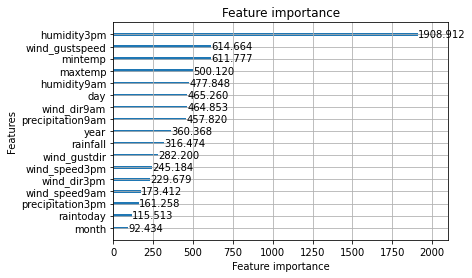

In [55]:
SalmonGums = dfs['SalmonGums']
X = SalmonGums[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = SalmonGums['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9991277661120981
CROSS_VAL_SCORE IS (0.9872991363795045, 0.008831283323809834)
PRECISION_SCORE TEST IS:   1.0
RECALL_SCORE TEST IS:   0.9490740740740741
F1_SCORE TEST IS:   0.9738717339667459


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

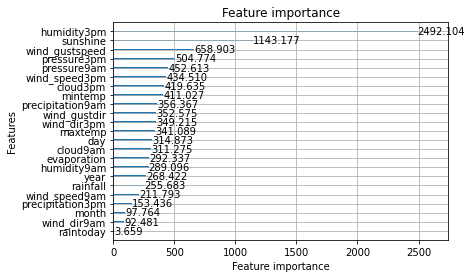

In [56]:
Sydney = dfs['Sydney']
X = Sydney[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Sydney['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9917444245913574
CROSS_VAL_SCORE IS (0.9907856557083285, 0.008958645469109355)
PRECISION_SCORE TEST IS:   0.9794520547945206
RECALL_SCORE TEST IS:   0.9501661129568106
F1_SCORE TEST IS:   0.9645868465430018


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

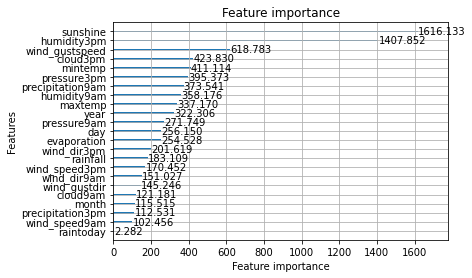

In [57]:
SydneyAirport = dfs['SydneyAirport']
X = SydneyAirport[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = SydneyAirport['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9958655206179958
CROSS_VAL_SCORE IS (0.989324955826597, 0.012744039231880515)
PRECISION_SCORE TEST IS:   0.9801980198019802
RECALL_SCORE TEST IS:   0.8918918918918919
F1_SCORE TEST IS:   0.9339622641509434


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

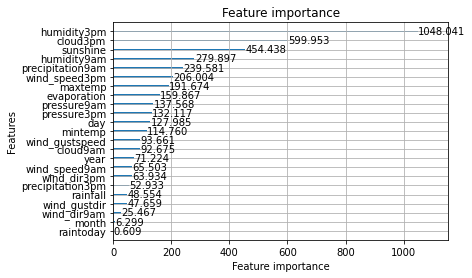

In [58]:
Townsville = dfs['Townsville']
X = Townsville[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Townsville['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9900390039003901
CROSS_VAL_SCORE IS (0.9960489933397344, 0.004422958648611683)
PRECISION_SCORE TEST IS:   0.9603960396039604
RECALL_SCORE TEST IS:   0.9238095238095239
F1_SCORE TEST IS:   0.941747572815534


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

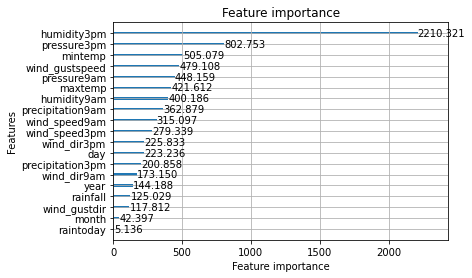

In [59]:
Tuggeranong = dfs['Tuggeranong']
X = Tuggeranong[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Tuggeranong['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   1.0
CROSS_VAL_SCORE IS (0.9977472255601894, 0.0054885274781051084)
PRECISION_SCORE TEST IS:   1.0
RECALL_SCORE TEST IS:   0.9722222222222222
F1_SCORE TEST IS:   0.9859154929577464


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

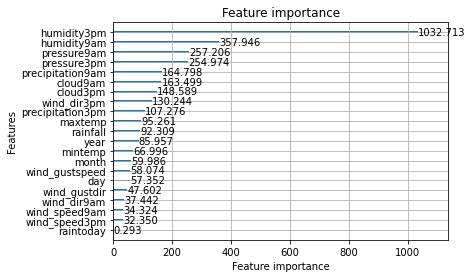

In [60]:
Uluru = dfs['Uluru']
X = Uluru[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Uluru['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   0.9999999999999999
ROC_PREDIT TEST IS:   0.9982829289908054
CROSS_VAL_SCORE IS (0.9918695917279123, 0.00985199570321134)
PRECISION_SCORE TEST IS:   0.9830508474576272
RECALL_SCORE TEST IS:   0.9666666666666667
F1_SCORE TEST IS:   0.9747899159663865


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

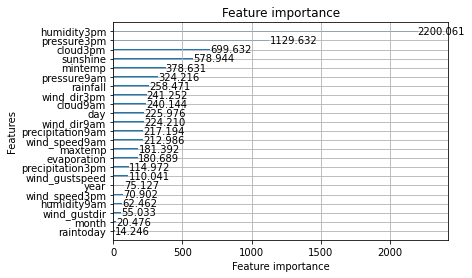

In [61]:
WaggaWagga = dfs['WaggaWagga']
X = WaggaWagga[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = WaggaWagga['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9778584510727368
CROSS_VAL_SCORE IS (0.9869983599068146, 0.01146276761912273)
PRECISION_SCORE TEST IS:   0.9821428571428571
RECALL_SCORE TEST IS:   0.9553349875930521
F1_SCORE TEST IS:   0.9685534591194969


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

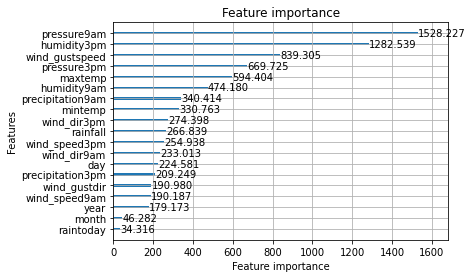

In [62]:
Walpole = dfs['Walpole']
X = Walpole[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Walpole['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9856959706959707
CROSS_VAL_SCORE IS (0.9871273197618982, 0.008292075720813183)
PRECISION_SCORE TEST IS:   0.9807692307692307
RECALL_SCORE TEST IS:   0.9306569343065694
F1_SCORE TEST IS:   0.9550561797752808


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

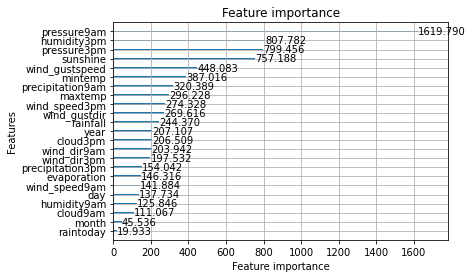

In [63]:
Watsonia = dfs['Watsonia']
X = Watsonia[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Watsonia['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9912035080304311
CROSS_VAL_SCORE IS (0.9836397640746684, 0.018779499381997692)
PRECISION_SCORE TEST IS:   0.9704142011834319
RECALL_SCORE TEST IS:   0.9371428571428572
F1_SCORE TEST IS:   0.9534883720930233


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

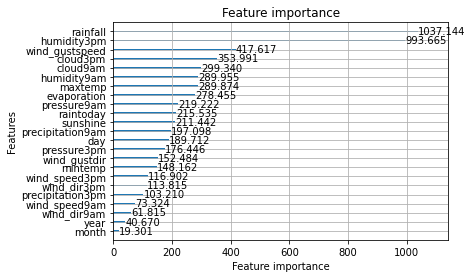

In [64]:
Williamtow = dfs['Williamtown']
X = Williamtow[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Williamtow['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9984289617486338
CROSS_VAL_SCORE IS (0.9896697722663303, 0.008720842476369183)
PRECISION_SCORE TEST IS:   1.0
RECALL_SCORE TEST IS:   0.9568627450980393
F1_SCORE TEST IS:   0.9779559118236473


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

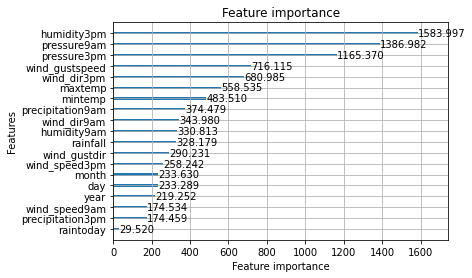

In [65]:
Witchcliffe = dfs['Witchcliffe']
X = Witchcliffe[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Witchcliffe['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\test\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9898298816568047
CROSS_VAL_SCORE IS (0.9914811991859542, 0.00753377142991392)
PRECISION_SCORE TEST IS:   0.9822485207100592
RECALL_SCORE TEST IS:   0.9595375722543352
F1_SCORE TEST IS:   0.9707602339181286


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

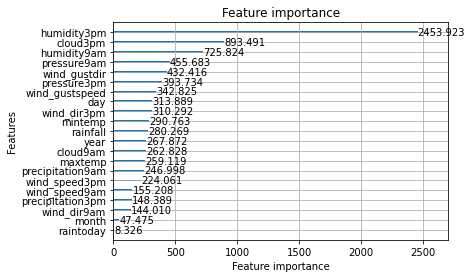

In [66]:
Wollongong = dfs['Wollongong']
X = Wollongong[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Wollongong['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   1.0
CROSS_VAL_SCORE IS (0.9932606316179096, 0.01306143976032611)
PRECISION_SCORE TEST IS:   0.9615384615384616
RECALL_SCORE TEST IS:   1.0
F1_SCORE TEST IS:   0.9803921568627451


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

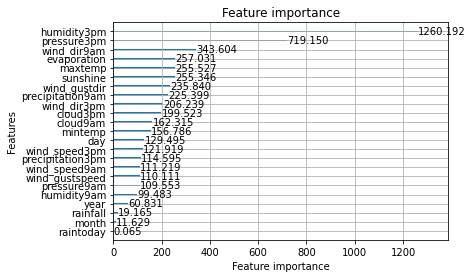

In [67]:
Woomera = dfs['Woomera']
X = Woomera[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Woomera['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

# More Complex Historical Series Models

## Prophet

In [68]:
#!pip install fbprophet --user

^C


## Sarimax

In [69]:
import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose as seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from random import random
# contrived dataset
#dfs2 = dict(tuple(seasoned_rain_all.groupby('location')))
#cities_list = list(dfs2)
#print(cities_list)
#Adelaide_all = dfs2['Adelaide']
#data = [x + random() for x in range(1, 100)]
# fit model
#model = SARIMAX(Adelaide_all, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
#model_fit = model.fit(disp=False)
# make prediction
#yhat = model_fit.predict(len(Adelaide_all), len(Adelaide_all))
#print(yhat)

<ipython-input-70-52c15a883e78>:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(buf.raintomorrow.dropna(),freq=365)


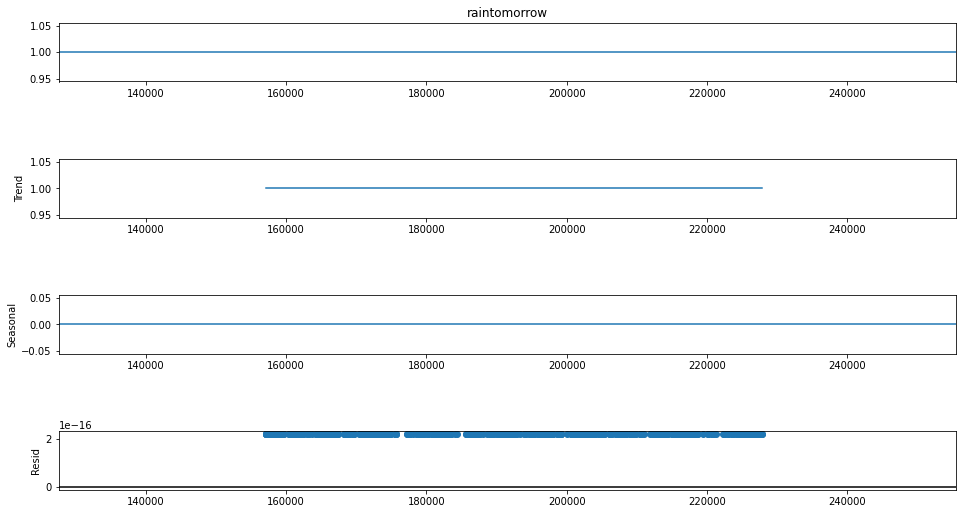

In [70]:
#buf = seasoned_rain_all[(seasoned_rain_all.raintomorrow==1)&(seasoned_rain_all.location=='Adelaide')].copy()

# contrived dataset
#dfs2 = dict(tuple(seasoned_rain_all.groupby('location')))
#cities_list = list(dfs2)
#Adelaide_all = dfs2['Adelaide']
#res = sm.tsa.seasonal_decompose(buf.raintomorrow.dropna(),freq=365)
#fig = res.plot()
#fig.set_figheight(8)
#fig.set_figwidth(15)
#plt.show()

### !pip install statsmodels

In [71]:
#from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.stattools import adfuller
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from matplotlib.pylab import rcParams
#from pmdarima import auto_arima
#from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
#import statsmodels.api as sm
#from statsmodels.tsa.statespace.sarimax import SARIMAX

#Find and list your cities from primary table
#dfs2 = dict(tuple(seasoned_rain_all.groupby('location')))
#cities_list = list(dfs2)
#print(cities_list)
#Adelaide_all = dfs2['Adelaide']



#Sarimax_model = auto_arima(Adelaide_all['raintomorrow'],
#                       start_P=1,
#                       start_q=1,
#                       max_p=3,
#                       max_q=3,
#                       m=12,
#                       seasonal=True,
#                       d=None,
#                       D=1,
#                       trace=True,
#                       error_action='ignore',
#                       suppress_warnings=True,
#                       stepwise=True)
#Sarimax_model.summary()

In [72]:
Adelaide_all

NameError: name 'Adelaide_all' is not defined

In [ ]:
# SARIMAX example
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#from random import random
# contrived dataset
#rain_aus = [x + random() for x in range(1, 100)]
#wind = [x + random() for x in range(101, 200)]
# fit model
#model = SARIMAX(rain_merge, exog=wind, order=(1,0,0), seasonal_order=(2,1,0))
#model_fit = model.fit(disp=False)
# make prediction
#exog2 = [200 + random()]
#yhat = model_fit.predict(len(rain_aus), len(rain_aus), exog=[exog2])
#print(yhat)

In [ ]:
# SARIMAX example
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#from random import random
# contrived dataset
#rain_aus = [x + random() for x in range(1, 100)]
#wind = [x + random() for x in range(101, 200)]
# fit model
#model = SARIMAX(rain_aus, exog=wind, order=(2,0,1))
#model_fit = model.fit(disp=False)
# make prediction
#exog2 = [200 + random()]
#yhat = model_fit.predict(len(rain_aus), len(rain_aus), exog=[exog2])
#print(yhat)

# If you want to see tables by each city

In [ ]:
Albany = dfs['Albany']
Albury =  dfs['Albury']
AliceSprings = dfs['AliceSprings']
BadgerysCreek = dfs['BadgerysCreek']
Ballarat = dfs['Ballarat']
Bendigo = dfs['Bendigo']
Brisbane = dfs['Brisbane']
Cairns = dfs['Cairns']
Canberra = dfs['Canberra']
Cobar = dfs['Cobar']
CoffsHarbour = dfs['CoffsHarbour']
Dartmoor = dfs['Dartmoor']
Darwin = dfs['Darwin']
GoldCoast = dfs['GoldCoast']
Hobart = dfs['Hobart']
Katherine = dfs['Katherine']
Launceston = dfs['Launceston']
Melbourne = dfs['Melbourne']
MelbourneAirport = dfs['MelbourneAirport']
Mildura = dfs['Mildura']
More = dfs['Moree']
MountGambier = dfs['MountGambier']
MountGinini = dfs['MountGinini']
Newcastle = dfs['Newcastle']
Nhil = dfs['Nhil']
NorahHead = dfs['NorahHead']
NorfolkIsland = dfs['NorfolkIsland']
Nuriootpa = dfs['Nuriootpa']
PearceRAAF = dfs['PearceRAAF']
Penrith = dfs['Penrith']
Perth = dfs['Perth'
PerthAirport = dfs['PerthAirport']
Portland = dfs['Portland']
Richmond = dfs['Richmond']
Sale = dfs['Sale']
SalmonGums = dfs['SalmonGums']
Sydney = dfs['Sydney']
SydneyAirport = dfs['SydneyAirport']
Townsville = dfs['Townsville']
Tuggeranong = dfs['Tuggeranong']
Uluru = dfs['Uluru']
WaggaWagga = dfs['WaggaWagga']
Walpole = dfs['Walpole']
Watsonia = dfs['Watsonia']
Williamtow = dfs['Williamtown']
Witchcliffe = dfs['Witchcliffe']
Wollongong = dfs['Wollongong']

In [ ]:
#Else

#for i, g in seasoned_rain.groupby('location'):
#    globals()['seasoned_rain_city_' + str(i)] =  g

# sort the dataframe
#seasoned_rain.sort_values(by='location', axis=1, inplace=True)

# set the index to be this and don't drop
#seasoned_rain.set_index(keys=['location'], drop=False,inplace=True)

# get a list of names
#locations = seasoned_rain['location'].unique().tolist()
#locations
# now we can perform a lookup on a 'view' of the dataframe
#joe = df.loc[df.name=='joe']

# now you can query all 'joes'

# Interpret your General Model

1    25731
0    24366
Name: raintomorrow, dtype: int64
ROC_PREDIT TRAIN IS:   0.9989813872891019
ROC_PREDIT TEST IS:   0.9765921358697086
CROSS_VAL_SCORE IS (0.976186207829128, 0.0023951973233813924)
PRECISION_SCORE TEST IS:   0.9618168657256605
RECALL_SCORE TEST IS:   0.9130733550936265
F1_SCORE TEST IS:   0.9368114920243236


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

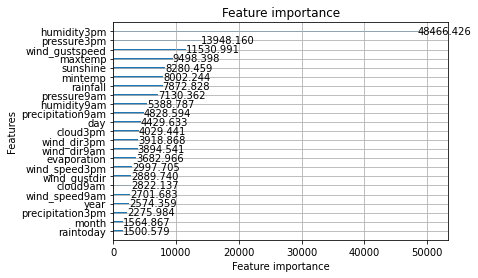

In [148]:
#Create you best model variables FOR YOUR SEASONAL CUT
X = seasoned_rain[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = seasoned_rain['raintomorrow']
#Create you best model variables FOR ALL DATA
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(y_train.value_counts())
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=400, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

[15:16:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


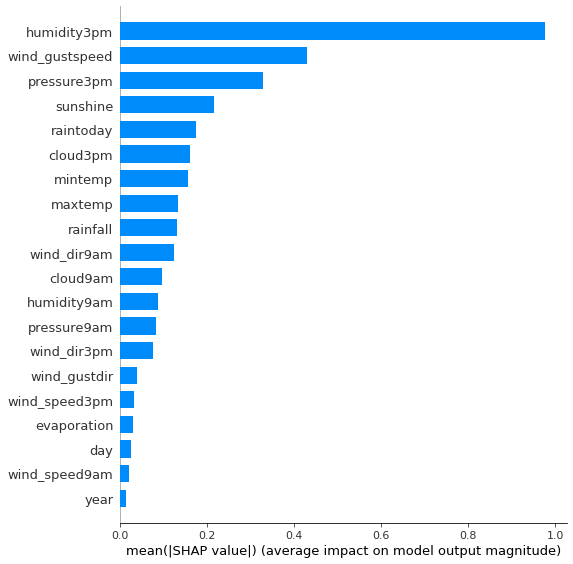

In [149]:
import shap
from xgboost import XGBClassifier
shap.initjs()

xgb = XGBClassifier(n_estimators=100, max_depth=2, importance_type='gain', colsample_bytree=0.3)
xgb.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb)
explainer

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [113]:
pd.DataFrame(xgb.predict_proba(X_test)[:, 1], columns=['prob']).query('0.2 < prob < 0.6 ')

<IPython.core.display.Javascript object>

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


prob
2      0.316308
4      0.513923
7      0.468146
9      0.307419
20     0.257022
...         ...
21451  0.399466
21453  0.574340
21461  0.273045
21469  0.211937
21470  0.255294

[6254 rows x 1 columns]

## Rainy Day

In [154]:
expected_value = explainer.expected_value
shap.force_plot(expected_value, shap_values[80],features= X.iloc[80], link='logit',feature_names=X.columns, show=False)#.savefig('output.png')

In [156]:
shap.force_plot(expected_value, shap_values[:80], X.iloc[:80], link='logit')

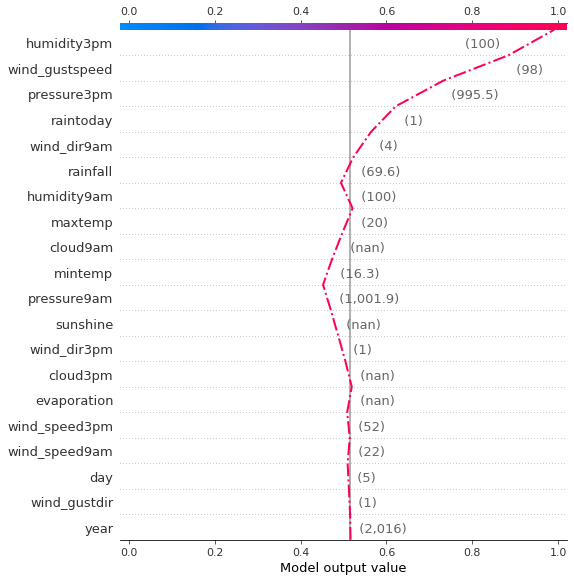

In [158]:
shap.decision_plot(base_value, shap_values[80], X_test.iloc[80], highlight=0, link='logit')

## Sunny Day

In [170]:
expected_value = explainer.expected_value
shap.force_plot(expected_value, shap_values[802],features= X.iloc[802], link='logit',feature_names=X.columns, show=False)#.savefig('output.png')

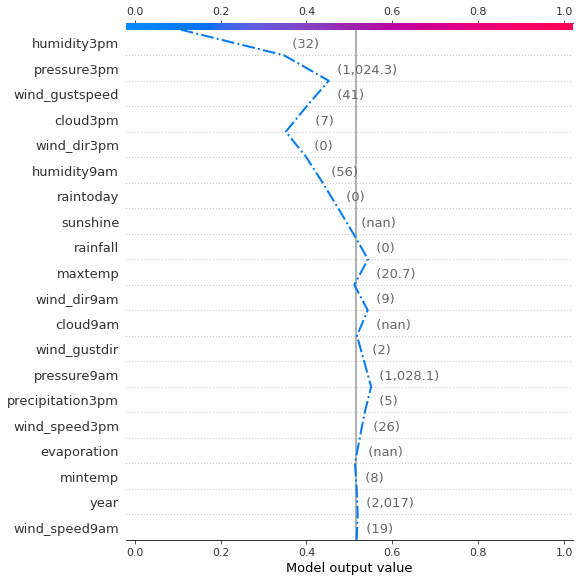

In [171]:
shap.decision_plot(base_value, shap_values[802], X_test.iloc[802], highlight=0, link='logit')

In [172]:
shap.force_plot(expected_value, shap_values[:802], X.iloc[:802], link='logit')

# Interpret Your Model on Sidney

ROC_PREDIT TRAIN IS:   1.0
ROC_PREDIT TEST IS:   0.9991277661120981
CROSS_VAL_SCORE IS (0.9833092443244669, 0.012585724064610906)
PRECISION_SCORE TEST IS:   1.0
RECALL_SCORE TEST IS:   0.9490740740740741
F1_SCORE TEST IS:   0.9738717339667459


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

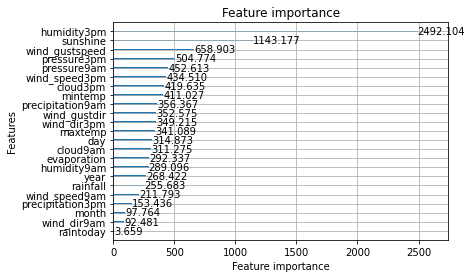

In [114]:
Sydney = dfs['Sydney']
X = Sydney[['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'raintoday', 'precipitation3pm', 'precipitation9am',
       'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'year', 'month', 'day']]
y = Sydney['raintomorrow']
#Split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalize your values for the model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=3, n_estimators=10, learning_rate=0.2, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#Apply your best model!
lgbm = LGBMClassifier(max_depth=9, n_estimators=300, learning_rate=0.1, colsample_bytree=.7, n_jobs=-1)
lgbm.fit(X_train, y_train)
#SEE YOUR SCORE BY ROC!
print('ROC_PREDIT TRAIN IS:  ', roc_auc_score(y_train, lgbm.predict_proba(X_train)[:,1]))
print('ROC_PREDIT TEST IS:  ',roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]))
#SCORE BY CROSS-VALIDATION
results = cross_val_score(lgbm, X_train_std, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
print('CROSS_VAL_SCORE IS', (np.mean(results), np.std(results)))
#Check Recall, Precision and F1
print('PRECISION_SCORE TEST IS:  ', precision_score(lgbm.predict(X_test), y_test))
print('RECALL_SCORE TEST IS:  ', recall_score(lgbm.predict(X_test), y_test))
print('F1_SCORE TEST IS:  ', f1_score(lgbm.predict(X_test), y_test))
plot_importance(lgbm, importance_type='gain')

## Rainy Day

[14:57:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


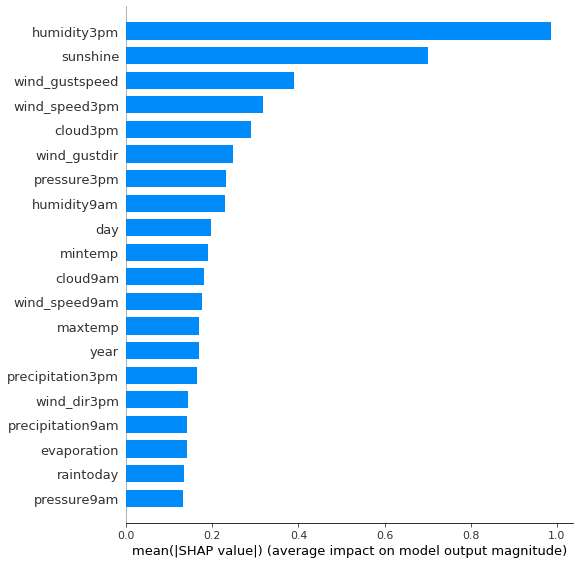

In [115]:
import shap
from xgboost import XGBClassifier
shap.initjs()

xgb = XGBClassifier(n_estimators=100, max_depth=2, importance_type='gain', colsample_bytree=0.3)
xgb.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb)
explainer

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [130]:
base_value = explainer.expected_value

N = 300
print(y_test.iloc[N])
shap.force_plot(base_value, shap_values[N], features=X_test.iloc[N], feature_names=X_train.columns)

1


In [174]:
shap.force_plot(expected_value, shap_values[:300], X.iloc[:300], link='logit')

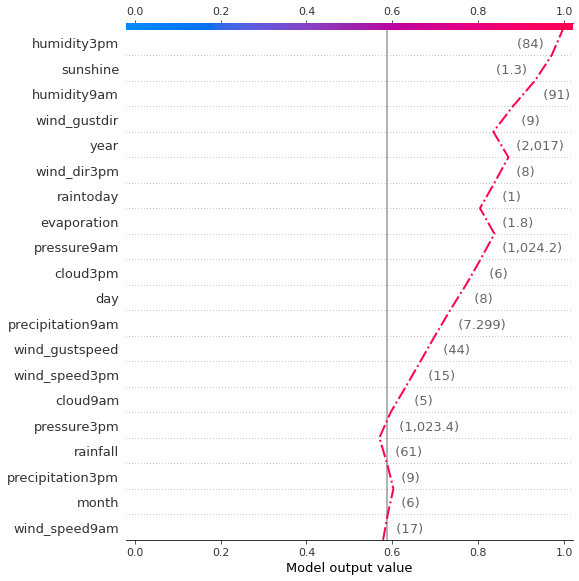

In [141]:
shap.decision_plot(base_value, shap_values[N], X_test.iloc[N], highlight=0, link='logit')

## Sunny Day

In [144]:
expected_value = explainer.expected_value
shap.force_plot(expected_value, shap_values[70],features= X.iloc[70], link='logit',feature_names=X.columns, show=False)#.savefig('output.png')

In [146]:
shap.force_plot(expected_value, shap_values[:70], X.iloc[:70], link='logit')

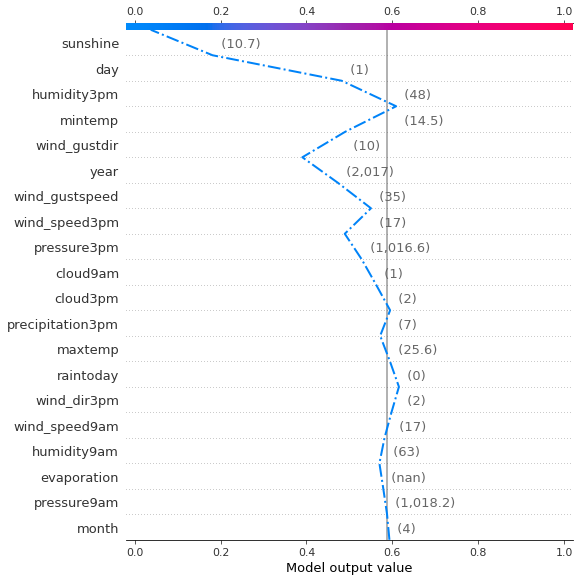

In [147]:
shap.decision_plot(base_value, shap_values[70], X_test.iloc[70], highlight=0, link='logit')